
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 5: $k$-NN Classification, ROC, and PCA

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited.

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
pd.set_option('display.max_columns', 25)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from statsmodels.api import OLS

import seaborn as sns
sns.set()

C:\Users\sugar\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools



## Continuing Cancer Classification from Gene Expressions

In this problem, we will continue to work with the 2-class (ALL vs. AML) cancer classification problem from homework 4. The dataset is provided in the file `data/hw4_enhance.csv` and is the same as the previous HW.  Recall: **0 indicates the ALL** class and **1 indicates the AML** class within `Cancer_type`, and columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will handle the high dimensionality of this problem directly by applying Principal Component Analysis (PCA), and then use the resulting PCA-transformed in logistic regression and $k$-NN modeling.

<div class='exercise'><b> Question 1 [20 pts]: Baseline Modeling </b></div>

First step is to split the observations into an approximate 80-20 train-test split.  Below is the same code from HW4 to do this for you (we again want to make sure everyone has the same splits). Use the training data set to answer the following questions:


**First step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). `Cancer_type` is again our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)

X_train, X_test, y_train, y_test =train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

**1.1** Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.

**1.2** Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.

**1.3** Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  Report the classification accuracy on both the train and test sets.

**1.4** Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `k = 1,2,5,10,20,50,100,200,500`. 

**1.5** Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.


<hr>

### Solutions

**1.1 Begin by normalizing all predictors just like you did in HW4.  Use these versions of the predictors throughout this assignment.**

In [4]:
# your code here
normalized_x_train=(X_train-X_train.min())/(X_train.max()-X_train.min()) #normalization 
normalized_x_train.describe()

normalized_x_test=(X_test-X_test.min())/(X_test.max()-X_test.min()) #normalization 
normalized_x_test.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,...,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.521900,0.687150,0.428496,0.465988,0.533584,0.489591,0.538567,0.550409,0.495196,0.334031,0.565051,0.498272,...,0.578692,0.496483,0.504205,0.495199,0.385312,0.321002,0.563333,0.540981,0.420553,0.520914,0.403908,0.491997
std,0.189456,0.164801,0.176141,0.191290,0.139465,0.211013,0.180306,0.172728,0.182104,0.158311,0.154197,0.188860,...,0.198255,0.166746,0.173335,0.169380,0.201798,0.161601,0.183045,0.182802,0.209879,0.202484,0.174322,0.167380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.430567,0.591452,0.314190,0.340344,0.444970,0.339775,0.427865,0.435116,0.381384,0.245950,0.481813,0.384830,...,0.441030,0.397085,0.402522,0.376562,0.241894,0.232169,0.452024,0.432256,0.285630,0.386056,0.301268,0.386250
50%,0.524879,0.703790,0.400219,0.466646,0.549577,0.474069,0.535236,0.568455,0.484707,0.321790,0.583144,0.521970,...,0.574291,0.502505,0.507359,0.469548,0.391591,0.307632,0.556613,0.529104,0.391091,0.528650,0.389592,0.485651
75%,0.643519,0.786007,0.545325,0.592139,0.610496,0.638307,0.631029,0.675841,0.624623,0.415356,0.657662,0.600796,...,0.722299,0.607422,0.606819,0.610389,0.514722,0.373763,0.688384,0.656917,0.562734,0.666292,0.503775,0.574866
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
normalized_x_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,AFFX-BioB-M_st,AFFX-BioB-3_st,...,U11863_at,U29175_at,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,0.551880,0.631528,0.482168,0.438776,0.618723,0.403753,0.591583,0.544518,0.621268,0.503159,0.592887,0.429101,...,0.537128,0.477589,0.558309,0.486270,0.485819,0.391604,0.590949,0.503939,0.370512,0.498539,0.537380,0.461455
std,0.120852,0.127453,0.149090,0.140154,0.141699,0.153665,0.155006,0.164288,0.128469,0.141734,0.160189,0.153374,...,0.177113,0.147707,0.139064,0.149080,0.164067,0.100772,0.164910,0.138239,0.138930,0.161129,0.154759,0.153690
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476264,0.557454,0.394956,0.352879,0.529837,0.308342,0.500545,0.429288,0.551025,0.418475,0.507330,0.332571,...,0.425708,0.383596,0.479238,0.388388,0.385852,0.334709,0.506111,0.410831,0.280240,0.405717,0.445447,0.356357
50%,0.559477,0.641672,0.478321,0.437090,0.631015,0.387398,0.587109,0.557519,0.632589,0.504952,0.611899,0.440909,...,0.524862,0.475118,0.551141,0.478502,0.492022,0.384691,0.614133,0.492102,0.358113,0.496963,0.521019,0.459238
75%,0.630576,0.712756,0.554837,0.522697,0.709618,0.493697,0.692712,0.659477,0.706408,0.578614,0.696565,0.535167,...,0.657066,0.570208,0.643646,0.590640,0.584703,0.442659,0.698660,0.583209,0.442772,0.600409,0.633784,0.556818
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**1.2 Fit an 'unregularized' multiple logistic regression model (set C=100000) with all the gene predictors from the data set (you did this in HW4).  Report the misclassification rate on both the train and test sets.**

In [6]:
# your code here

logmodel=LogisticRegression(C=100000,fit_intercept=True)
logmodel.fit(normalized_x_train,y_train.values.ravel())

#model on test model
pred_test = logmodel.predict(normalized_x_test)
accuracy_test=accuracy_score(y_test,pred_test,normalize=True)


pred_train = logmodel.predict(normalized_x_train)
accuracy_train=accuracy_score(y_train,pred_train,normalize=True)


In [7]:
print('The misclassification rate on the test set is {}.'.format(1-accuracy_test))
print('The misclassification rate on the train set is {}.'.format(1-accuracy_train))

The misclassification rate on the test set is 0.23841059602649006.
The misclassification rate on the train set is 0.0.


**1.3 Use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set (you did this in HW4).  eport the misclassification rate on both the train and test sets.**

In [90]:
fitted_lasso = LogisticRegressionCV(solver='liblinear',penalty='l1').fit(normalized_x_train,y_train.values.ravel())
fitted_lasso

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=0)

In [91]:
pred_train_lasso = fitted_lasso.predict(normalized_x_train)
pred_test_lasso = fitted_lasso.predict(normalized_x_test)

accuracy_train_lasso=accuracy_score(y_train,pred_train_lasso,normalize=True)
accuracy_test_lasso=accuracy_score(y_test,pred_test_lasso,normalize=True)


print('The misclassification rate of this model on training set is {}'.format(1-accuracy_train_lasso))
print('The misclassification rate of this model on test set is {}'.format(1-accuracy_test_lasso))

The misclassification rate of this model on training set is 0.09151414309484196
The misclassification rate of this model on test set is 0.17880794701986757


**1.4 Use 5-fold cross-validation to select $k$ for a $k$-NN classification model based on the full predictor set.  Choose between `ks = [1,2,3,4,5,7,9,10,15,25]`.  Report your chosen $k$, and report the misclassification rate on both the train and test sets for the model using your chosen $k$.**

In [92]:
ks = [1,2,3,4,5,7,9,10,15,25]
knnmodels = []
cv_scores = []
for k in ks:
    KNN = KNeighborsClassifier(n_neighbors = k)
    # train model with cv of 5
    cv_score = cross_val_score(KNN, normalized_x_train,y_train.values.ravel(),cv=5)
    mean = np.mean(cv_score)
    cv_score = np.append(cv_score,mean)
    cv_scores.append(cv_score)
    
cv_scores

[array([0.85950413, 0.78512397, 0.79338843, 0.81512605, 0.82352941,
        0.8153344 ]),
 array([0.84297521, 0.80165289, 0.7768595 , 0.77310924, 0.81512605,
        0.80194458]),
 array([0.88429752, 0.85123967, 0.83471074, 0.86554622, 0.8907563 ,
        0.86531009]),
 array([0.85950413, 0.80991736, 0.80165289, 0.80672269, 0.89915966,
        0.83539135]),
 array([0.87603306, 0.85123967, 0.84297521, 0.81512605, 0.89915966,
        0.85690673]),
 array([0.90909091, 0.85123967, 0.87603306, 0.84033613, 0.89915966,
        0.87517189]),
 array([0.90082645, 0.85123967, 0.89256198, 0.83193277, 0.88235294,
        0.87178276]),
 array([0.85950413, 0.79338843, 0.88429752, 0.83193277, 0.87394958,
        0.84861449]),
 array([0.88429752, 0.76033058, 0.87603306, 0.79831933, 0.84033613,
        0.83186332]),
 array([0.76859504, 0.66942149, 0.78512397, 0.71428571, 0.78991597,
        0.74546844])]

In [93]:
cv_scores_df = pd.DataFrame(np.array(cv_scores).reshape(-1,6))
cv_scores_df.columns=['1','2','3','4','5','mean']
k = ks.copy()
k[0] = 'k=1'
cv_scores_df.index=k
display(cv_scores_df)
print('The KNN model with k=7 has the highest mean score, and the variance of each validation set is low. Therefore, I pick k=7 for my KNN model. ')

,1,2,3,4,5,mean
k=1,0.859504,0.785124,0.793388,0.815126,0.823529,0.815334
2,0.842975,0.801653,0.776860,0.773109,0.815126,0.801945
3,0.884298,0.851240,0.834711,0.865546,0.890756,0.865310
4,0.859504,0.809917,0.801653,0.806723,0.899160,0.835391
5,0.876033,0.851240,0.842975,0.815126,0.899160,0.856907
7,0.909091,0.851240,0.876033,0.840336,0.899160,0.875172
9,0.900826,0.851240,0.892562,0.831933,0.882353,0.871783
10,0.859504,0.793388,0.884298,0.831933,0.873950,0.848614
15,0.884298,0.760331,0.876033,0.798319,0.840336,0.831863
25,0.768595,0.669421,0.785124,0.714286,0.789916,0.745468


The KNN model with k=7 has the highest mean score, and the variance of each validation set is low. Therefore, I pick k=7 for my KNN model. 


In [94]:
KNN = KNeighborsClassifier (n_neighbors = 7)
KNN.fit(normalized_x_train,y_train.values.ravel())
knn_train_pred = KNN.predict(normalized_x_train)
knn_test_pred = KNN.predict(normalized_x_test)
accuracy_train = accuracy_score(y_train,knn_train_pred,normalize=True)
accuracy_test = accuracy_score(y_test,knn_test_pred,normalize=True)
mis_train = 1-accuracy_train
mis_test = 1-accuracy_test
print('The misclassification rate on train set of KNN model with k 7 is {}'.format(mis_train))
print('The misclassification rate on test set of KNN model with 7 is {}'.format(mis_test))

The misclassification rate on train set of KNN model with k 7 is 0.09816971713810319
The misclassification rate on test set of KNN model with 7 is 0.13907284768211925


Report your chosen  k, and report the misclassification rate on both the train and test sets for the model using your chosen  k.

**1.5 Provide the confusion matrix for all 3 models above and report the false positive and false negative rates (all in the test set).  Briefly interpret what you notice.**

In [95]:
# your code here
from sklearn.metrics import confusion_matrix
#unregularized logistic  
cm1 = confusion_matrix(y_test, pred_test)

#lasso logistic 
cm2 = confusion_matrix(y_test, pred_test_lasso)

#knn
cm3 = confusion_matrix(y_test, knn_test_pred)

display (cm1, cm2, cm3)

array([[65, 12],
       [24, 50]])

array([[67, 10],
       [17, 57]])

array([[67, 10],
       [11, 63]])

In [110]:
FP_unreg = cm1[0][1]
TP_unreg = cm1[1][1]
FN_unreg = cm1[1][0]
TN_unreg = cm1[0][0]
FPR_unreg = FP_unreg/(FP_unreg+TN_unreg) 
FNR_unreg = FN_unreg/(TP_unreg+FN_unreg)

FP_lasso = cm2[0][1]
TP_lasso = cm2[1][1]
FN_lasso = cm2[1][0]
TN_lasso = cm2[0][0]
FPR_lasso = FP_lasso/(FP_lasso+TN_lasso) 
FNR_lasso = FN_lasso/(TP_lasso+FN_lasso)

FP_knn = cm3[0][1]
TP_knn = cm3[1][1]
FN_knn = cm3[1][0]
TN_knn = cm3[0][0]
FPR_knn = FP_knn/(FP_knn+TN_knn) 
FNR_knn = FN_knn/(TP_knn+FN_knn)

print('For the unregulated regression model, false positive rate is {},'.format(FPR_unreg) + ' false negative rate is {}'.format(FNR_unreg))
print('For the lasso model, false positive rate is {},'.format(FPR_lasso) + ' false negative rate is {}'.format(FNR_lasso))
print('For the knn model, false positive rate is {},'.format(FPR_knn) + ' false negative rate is {}'.format(FNR_knn))



For the unregulated regression model, false positive rate is 0.15584415584415584, false negative rate is 0.32432432432432434
For the lasso model, false positive rate is 0.12987012987012986, false negative rate is 0.22972972972972974
For the knn model, false positive rate is 0.12987012987012986, false negative rate is 0.14864864864864866


*your answer here*

The knn model shows the best power with both lowest false positive rate. and lowest false negative rate. 

<div class='exercise'><b> Question 2 [20 pts]: Performing Principal Components Analysis </b></div>

**2.1** Create the full PCA decomposition of `X_train` and apply the transformation to both `X_train` and `X_test`.  Report the shape of both of these.  What is the limiting factor for the maximum number of PCA components for this data set? 

**2.2** PCA is often solely used to help in visualizing high-dimensional problems.  Plot the scatterplot of the second PCA vector of train on the $Y$-axis and the first PCA vector of train on the $X$-axis (be sure to denote the classes via different color/markings).  In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.

**2.3** Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).

**2.4** Plot explained variability in the predictors on the $Y$-axis and the PCA component number on the $X$-axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and justify your choice with 1-3 sentences.

<hr>

### Solutions

**2.1 Create the full PCA decomposition of X_train and apply the transformation to both X_train and X_test. Report the shape of both of these. What is the limiting factor for the maximum number of PCA components for this data set?**

In [165]:
#Standardize x_test and x_train
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [204]:
# your code here
pca = PCA()
pca_train = pca.fit(X_train_scaled) 
pca_train_X = pca_train.transform(X_train_scaled)
pca_test_X = pca_train.transform(X_test_scaled)

In [205]:
print('The shape of PCA decomposition of X_train is {}'.format(pca_train_X.shape))
print('The shape of PCA decomposition of X_test is {}'.format(pca_test_X.shape))

The shape of PCA decomposition of X_train is (601, 601)
The shape of PCA decomposition of X_test is (151, 601)


*Your answer here*

The maximum number of PCA components is bound by the smaller number of number of observations and number of columns. 

**2.2 PCA is often solely used to help in visualizing high-dimensional problems. Plot the scatterplot of the second PCA vector on the  𝑌 -axis and the first PCA vector on the  𝑋 -axis (be sure to denote the classes via different color/markings). In 2-3 sentences, explain why using the scatterplot of the top 2 PCA vectors is a useful approach to visualize a high dimensional classification problem.**

In [206]:
pca_train_X.shape

(601, 601)

Text(0.5,1,'Test set')

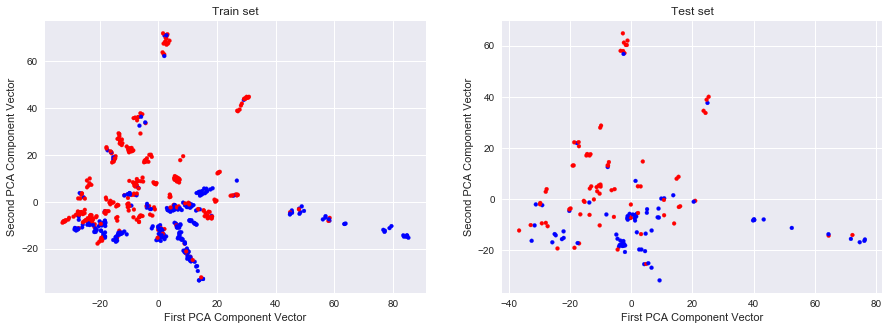

In [244]:
# your code here
# pca_train_X[:,0]
# pca_train.components_[:,1]
y_train.shape
color = []
for i in y_train:
    if i == 0:
        color.append('r')
    else:
        color.append('b')
        
color1 = []
for i in y_test:
    if i == 0:
        color1.append('r')
    else:
        color1.append('b')

plt.figure(figsize=(15,5))        
plt.subplot(1, 2, 1)
plt.scatter(pca_train_X[:,0],pca_train_X[:,1],color=color,s = 15)
plt.xlabel('First PCA Component Vector')
plt.ylabel('Second PCA Component Vector')
plt.title('Train set')


plt.subplot(1, 2, 2)
plt.scatter(pca_test_X[:,0],pca_test_X[:,1],color=color1,s=15)
plt.xlabel('First PCA Component Vector')
plt.ylabel('Second PCA Component Vector')
plt.title('Test set')



*your answer here*


In the list of p principle components Z1,..., Zp, the Zi 's are ordered in decreasing order in the amount of captured observed variance. Therefore the top 2 components can best classify the outcome.

**2.3 Determine and report the variance explained in `X_train` based on the top 2 PCA vectors.  Determine and report how many PCA vectors are needed so that 90\% of the variability in the predictors is explained, and create a plot to illustrate this result (Hint: look at cumulative explained variability vs. number of PCA components used).**

The variance explained in X_train based on the top 2 PCA vectors is 0.11219678772764469.
231 PCA vectors are needed so that 90% of the variability is explained.


Text(0,0.5,'Cumulative variance explained')

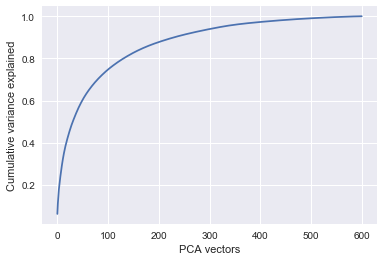

In [262]:
# your code here
var_2vec = np.sum(pca_train.explained_variance_ratio_[0:2])
print('The variance explained in X_train based on the top 2 PCA vectors is {}.'.format(var_2vec))
cumsum = np.cumsum(pca_train.explained_variance_ratio_)
vec_needed=np.where(cumsum >= 0.9)
print('{} PCA vectors are needed so that 90% of the variability is explained.'.format(vec_needed[0][0]))

ind = [i for i in range(len(cumsum))]
plt.plot(ind, cumsum)
plt.xlabel('PCA vectors')
plt.ylabel('Cumulative variance explained')


**2.4 Plot explained variability in the predictors on the  𝑌 -axis and the PCA component number on the 𝑋 -axis. Select a reasonable value for the number of components that balances representativeness (of the predictors) with parsimony and ustify your choice in 1-3 sentences.**

The reasonable value for the number of components is 100 because starting from 100th PCA vector, the explained variance is very close to 0 and thus not very representative. Even though some components after the 100th also capture some variance, but to minimize overfitting, I decide to exclude these vectors from the model.


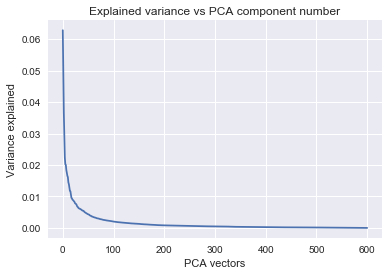

In [265]:
#your code here
plt.plot(ind, pca_train.explained_variance_ratio_)
plt.xlabel('PCA vectors')
plt.ylabel('Variance explained')
plt.title('Explained variance vs PCA component number')

print('The reasonable value for the number of components is 100 because starting from 100th PCA vector, the explained variance is very close to 0 and thus not very representative. Even though some components after the 100th also capture some variance, but to minimize overfitting, I decide to exclude these vectors from the model.')

<div class='exercise'><b> Question 3 [30 pts]: Principal Components Regression (PCR) </b></div>

**3.1** Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set. How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?

**3.2** Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`.

**3.3** Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).

**3.4** Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.

**3.5** Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction?  If you were to predict real cancer patients, how would use these models to predict cancer type?

<hr>

### Solutions

**3.1 Fit three separate Logistic Regression models using principal components as the predictors: (1) with just the first 2 PCA vectors, (2) with the number of component vectors your chose from 2.4 above, and (3) with the number of components that explain at least 90% of the variability in the predictor set.  How do the classification accuracy values on both the training and test sets compare with the models fit in Question 1?**

In [270]:
# your code here
logreg=LogisticRegression(C=100000,fit_intercept=True, solver='liblinear')

# 1. with just the first 2 PCA vectors
logreg.fit(pca_train_X[:,0:2],y_train.values.ravel())

#model on test model
pred_test_1 = logreg.predict(pca_test_X[:,0:2])
pred_train_1 = logreg.predict(pca_train_X[:,0:2])
accuracy_test=accuracy_score(y_test,pred_test_1,normalize=True)
accuracy_train=accuracy_score(y_train,pred_train_1,normalize=True)

print('The misclassification rate of the first logreg model on training set is {}'.format(1-accuracy_train))
print('The misclassification rate of the first logreg model on test set is {}'.format(1-accuracy_test))

# 2. with the number of component vectors your chose from 2.4 above
n_components = 100
logreg.fit(pca_train_X[:,0:n_components],y_train.values.ravel())

pred_test_2 = logreg.predict(pca_test_X[:,0:n_components])
pred_train_2 = logreg.predict(pca_train_X[:,0:n_components])
accuracy_test=accuracy_score(y_test,pred_test_2,normalize=True)
accuracy_train=accuracy_score(y_train,pred_train_2,normalize=True)

print('The misclassification rate of the second model on training set is {}'.format(1-accuracy_train))
print('The misclassification rate of the second model on test set is {}'.format(1-accuracy_test))

# your code here 

# 3. with the number of components that explain at least 90% of the variability

logreg.fit(pca_train_X[:,0:231],y_train.values.ravel())

#model on test model
pred_test_3 = logreg.predict(pca_test_X[:,0:231])
pred_train_3 = logreg.predict(pca_train_X[:,0:231])

accuracy_test=accuracy_score(y_test,pred_test_3,normalize=True)
accuracy_train=accuracy_score(y_train,pred_train_3,normalize=True)
print('The misclassification rate of the third model on training set is {}'.format(1-accuracy_train))
print('The misclassification rate of the third model on test set is {}'.format(1-accuracy_test))

The misclassification rate of the first logreg model on training set is 0.24126455906821964
The misclassification rate of the first logreg model on test set is 0.19867549668874174
The misclassification rate of the second model on training set is 0.08485856905158073
The misclassification rate of the second model on test set is 0.20529801324503316
The misclassification rate of the third model on training set is 0.0
The misclassification rate of the third model on test set is 0.2516556291390728


*your answer here*


For test set, KNN model has the best classification accuracy with lowest misclassication rate of 0.139. The PCA models have the misclassification on test set around 0.2. 


For train set, The misclassification rate for PCA models are very dependent on the number of components chosen. When we chose a large number of components, the accuracy rate is high but the test set accuracy is very low. When we chose components number to be 2, the train set variance is not well captured, and thus the accuracy rate for train set is also very low (missclassification = 0.24).



**3.2 Use cross-validation to determine the best number of principal components. Try out the 3 values from the previous sub-part and optionally include other values as well. For the best performing model according to cross-validation, interpret what the model says about the relationship between `M31523_at` and `Cancer_type`**.

In [ ]:
# your code here


**3.3 Another way to evaluate models in a classification setting is through an Area-under-the-ROC-Curve (AUC). Briefly explain what the AUC and the ROC are trying to do and how this approach differs (and may be prefered) from evaluating models based on misclassification rate (as you have done thus far in this problem set).**

*your answer here*

*The ROC curve is a graph illustrating the disrimination capability of a binary classifer at all classification thresholds, created by plotting true positive rate against the false positive rate at different thresholds. AUC is the two-dimentional area under the roc curve, which represents the degree of separability or the capability of a binary classifier in discriminating two classes.*

*The misclassification rate measure of a model depends on the threshold chosen, whereas AUC gives an broader aggregate measure of performance across all possible discrimination thresholds*

**3.4 Evaluate all 6 predictive models (7 if you optionally found a better number of principal components in 3.2) seen in problems 1 and 3 via Area-under-the-ROC-Curve (AUC) on the test set. For the best model with the best AUC, plot the ROC. Decide an appropriate strategy for breaking ties, if there are any. Briefly interpret your plot.**

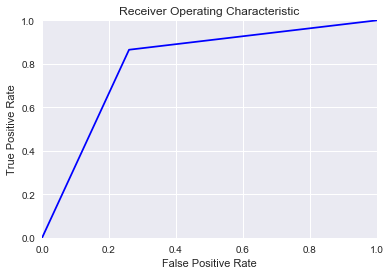

0.8025623025623025 0.7929097929097928 0.7479817479817481


In [268]:
# your code here

#from 3.3
score_1 = metrics.roc_auc_score(y_test, pred_test_1)
score_2 = metrics.roc_auc_score(y_test, pred_test_2)
score_3 = metrics.roc_auc_score(y_test, pred_test_3)


# Warning suppose the best model is score_1
fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test_1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(score_1, score_2, score_3)

*The ROC curves is close to the left-hand border and the top borader of the ROC space, which indicates that the model is relatively more accurate in classification*

**3.5 Based on AUC, is there one clear stand-out winner or are a lot of models similar in prediction? If you were to predict real cancer patients, how would use these models to predict cancer type?**

*your answer here*


<div class='exercise'><b> Question 4: COMPAS [30 points] </b></div>

This problem is unrelated to the first 3 problems, and steps through analyzing the COMPAS data set `compas.csv`.  The variables are roughly explained in the `compas_datadict.csv` file, and ProPublica's analysis is publically available here: https://github.com/propublica/compas-analysis.

**4.1** Split the data into 80% training and 20% test stratified by race. Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.

**4.2** Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.

**4.3** With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences?  Explain in 3-5 sentences.

**4.4**. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models: $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor. 

**4.5**. Refit the models in 4.4 without race as a predictor.  Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set.  How do these compare to the models when race is included as a predictor?

**4.6**. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.

<hr>

### Solutions

**4.1 Split the data into 80% training and 20% test stratified by race.  Before splitting you may want to process the categorical predictors first so you don't have to do it separately in tain and test later.**

In [ ]:
compas_df = pd.read_csv('data/compas.csv')

# your code here



**4.2 Do a little EDA: explore what variables are related to race. Report 3 variables that appear to have significant differences between Caucasians and African Americans, and provide visuals and numerical summaries to support these chosen variables.**

In [ ]:
# your code here


**4.3 With respect to these 3 chosen variables, how could bias in the data or data collection be impacting or causing these differences? Explain in 3-5 sentences.**

*your answer here*

**4.4. Build 2 seperate models to predict recidivism (`two_year_recid`) from these data (2 different 'classes' of models:  $k$-NN, linear, logistic, etc.) and be sure to include race as a predictor.**

In [ ]:
# your code here


**4.5. Refit the models in 4.4 without race as a predictor. Report the overall misclassifcation rates, and compare the differences in false positive and false negative rates between Caucasians and African Americans in these models on the test set. How do these compare to the models when race is included as a predictor?**

In [ ]:
# your code here


**4.6. Given your exploration and modeling of the data, should a predictive tool be trusted to be unbiased even if it doesn’t explicitly use a variable such as race to predict future crime?  Why or why not?  Why is the bias still occurring or not occurring?  Explain in 3-6 sentences total.**

*your answer here*


---